# New Venus Edits 
#### After the old ones got deleted...

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy import interpolate
from scipy.interpolate import interp1d

In [3]:
import seaborn as sns

In [4]:
cb_palette= sns.color_palette("colorblind")

#### Lambert Scaling Function

In [5]:
# To convert to phase angle= 0 use the lambertian phase integral (PSG eqn 77) to simulate full disk view
def get_scale_factor_lambert(phase_angle): # phase angle in degrees
    scale_val= (1/np.pi)*(np.sin(np.deg2rad(phase_angle))+(np.pi-np.deg2rad(phase_angle))*np.cos(np.deg2rad(phase_angle)))
    return scale_val

#### Read in all data sources

In [8]:
# perez-hoyos et al. 2018
hoyos= np.genfromtxt('HOYOS_fig8_spectrum151.txt')
# meadows 2006
meadows= pd.read_csv('venus_meadows_smoothed.csv')
# SPICAV / D’Aversa et al. 2019
spicav= pd.read_csv('spicav_data_fig1.csv')
# Wallace et al. 1972
wallace=np.genfromtxt('wallace_1972_geo_albedo.txt')
# Akatsuki/ Lee et al. 2021 365 nm (fig. 1)(FWHM =7nm @ effect. wavelength)
akatsuki_365= np.genfromtxt('akatsuki_fig1a_365nm.txt')
# Akatsuki/ Lee et al. 2021 283 nm (fig. 2)(FWHM =7nm @ effect. wavelength)
akatsuki_283= np.genfromtxt('Lee_Akatsuki_fig1b_283nm.txt')
# Mallama et al. 2017 Johnson Cousins filters 
mallama_jc= np.genfromtxt('JohnsonCousins_Mallama_Venus.txt')
# Irvine 1968, sph. albedo
irvine= np.genfromtxt('Irvine_1968_spherical_albedo_table2.txt')
# Moroz et al. 1985, table 6-1 monochromatic bond albedo
moroz= np.genfromtxt('moroz_table_6_1_bondalbedo.txt')
#barker
barker= np.genfromtxt('barker1975_fig8_venus_int.txt')
# Roberge et al. 2017 synthetic SMART data for each SS planet
roberge= pd.read_csv('Roberge2017_geometricalbedo_allplanets.csv')

##### For the akatsuki data need to convert all data to phase 0 for single point data
- Taking the lowest phase angle data points (all <10 degrees), scaling each of them to phase 0, then taking average of scaled 0 values
- This should be done for both 283 and 385 nm data

##### Describe data with this function

In [9]:
def describe_array(arr):
    mean_val = np.mean(arr)
    median_val = np.median(arr)
    min_val = np.min(arr)
    max_val = np.max(arr)
    print(f"Mean: {mean_val}")
    print(f"Median: {median_val}")
    print(f"Min: {min_val}")
    print(f"Max: {max_val}")

In [10]:
phase_zero_283=[]
for x,y in akatsuki_283:
    adjusted_vals= y/get_scale_factor_lambert(x)
    phase_zero_283.append(adjusted_vals)
phase_zero_365=[]
for x,y in akatsuki_365:
    adjusted_vals= y/get_scale_factor_lambert(x)
    phase_zero_365.append(adjusted_vals)
print('283 data:'),describe_array(phase_zero_283),print('365 data:'), describe_array(phase_zero_365);

283 data:
Mean: 0.18132558168598306
Median: 0.1817280892747596
Min: 0.1783513801429559
Max: 0.18329024876732739
365 data:
Mean: 0.3198912254445475
Median: 0.3213963491013047
Min: 0.2962617190195282
Max: 0.336107204640497


In [11]:
akatsuki_points_lee= np.array([[0.283,np.median(phase_zero_283)],[0.365, np.median(phase_zero_365)]])

## Smoothing the Perez-Hoyos data
- Data smoothed to improve appearance and reduce noise

In [12]:
def moving_average_smoothing(data, window_size):
    data = np.array(data)
    n = len(data)
    half_window = int(np.ceil(window_size * n / 2))
    
    smoothed_data = []
    
    for i in range(n):
        # Define the window range
        start = max(0, i - half_window)
        end = min(n, i + half_window + 1)
        
        # Compute the median of the window
        window = data[start:end]
        median_value = np.mean(window)
        
        # Append the median value to the smoothed data
        smoothed_data.append(median_value)
    
    return np.array(smoothed_data)
mask = hoyos[:, 0] > 0.309

averaged_data_point5 = moving_average_smoothing(hoyos[mask][:, 4], 0.005)
averaged_data_point1 = moving_average_smoothing(hoyos[:,4], 0.001)
averaged_data_point05= moving_average_smoothing(hoyos[:,4], 0.0005)

In [16]:
mask = hoyos[:, 0] > 0.309
#hoyos[mask][:, 4]

## so for every 2 data points= 1 spectral resolution unit
# if the resolution is binned within that then it shouldnt change the resolution right?

In [11]:
data = hoyos[:,4]
n = len(data)
half_window = int(np.ceil(0.001 * n / 2)) #window=0.001

In [12]:
def resolution(data, window_size):
    data = np.array(data)
    n = len(data)
    half_window = int(np.ceil(window_size * n / 2))
    print(half_window*2)

In [13]:
resolution(hoyos[:,4], 0.001)

2


# The Tri-Plot
- Barker data has to be multiplied by 0.94 to use the spherical albedo data (see fig 8 in paper)
    - data was saved as "reflectivity" (0-1) as seen on left y axis in figure, but to convert to right axis / sph. albedo, need to mult by 0.94

In [28]:
cb_palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## The composite spectrum to include in panel C

In [22]:
x_1= list(spicav[spicav['x']<0.308]['x'])
y_1= list(spicav[spicav['x']<0.308]['y'])

x_2= hoyos[hoyos[:,0]>0.306][:,0]
y_2= (averaged_data_point5*1.13)[:-1]

x_new= np.concatenate((x_1, x_2))
y_new= np.concatenate((y_1, y_2))

composite_df= pd.DataFrame({'x_1': x_new, 'y_1': y_new})

# x_dashed=composite_df[(composite_df['x_1'] > 1.491) & (composite_df['x_1'] < 1.4965)]['x_1']
# y_dashed=composite_df[(composite_df['x_1'] > 1.491) & (composite_df['x_1'] < 1.4965)]['y_1']

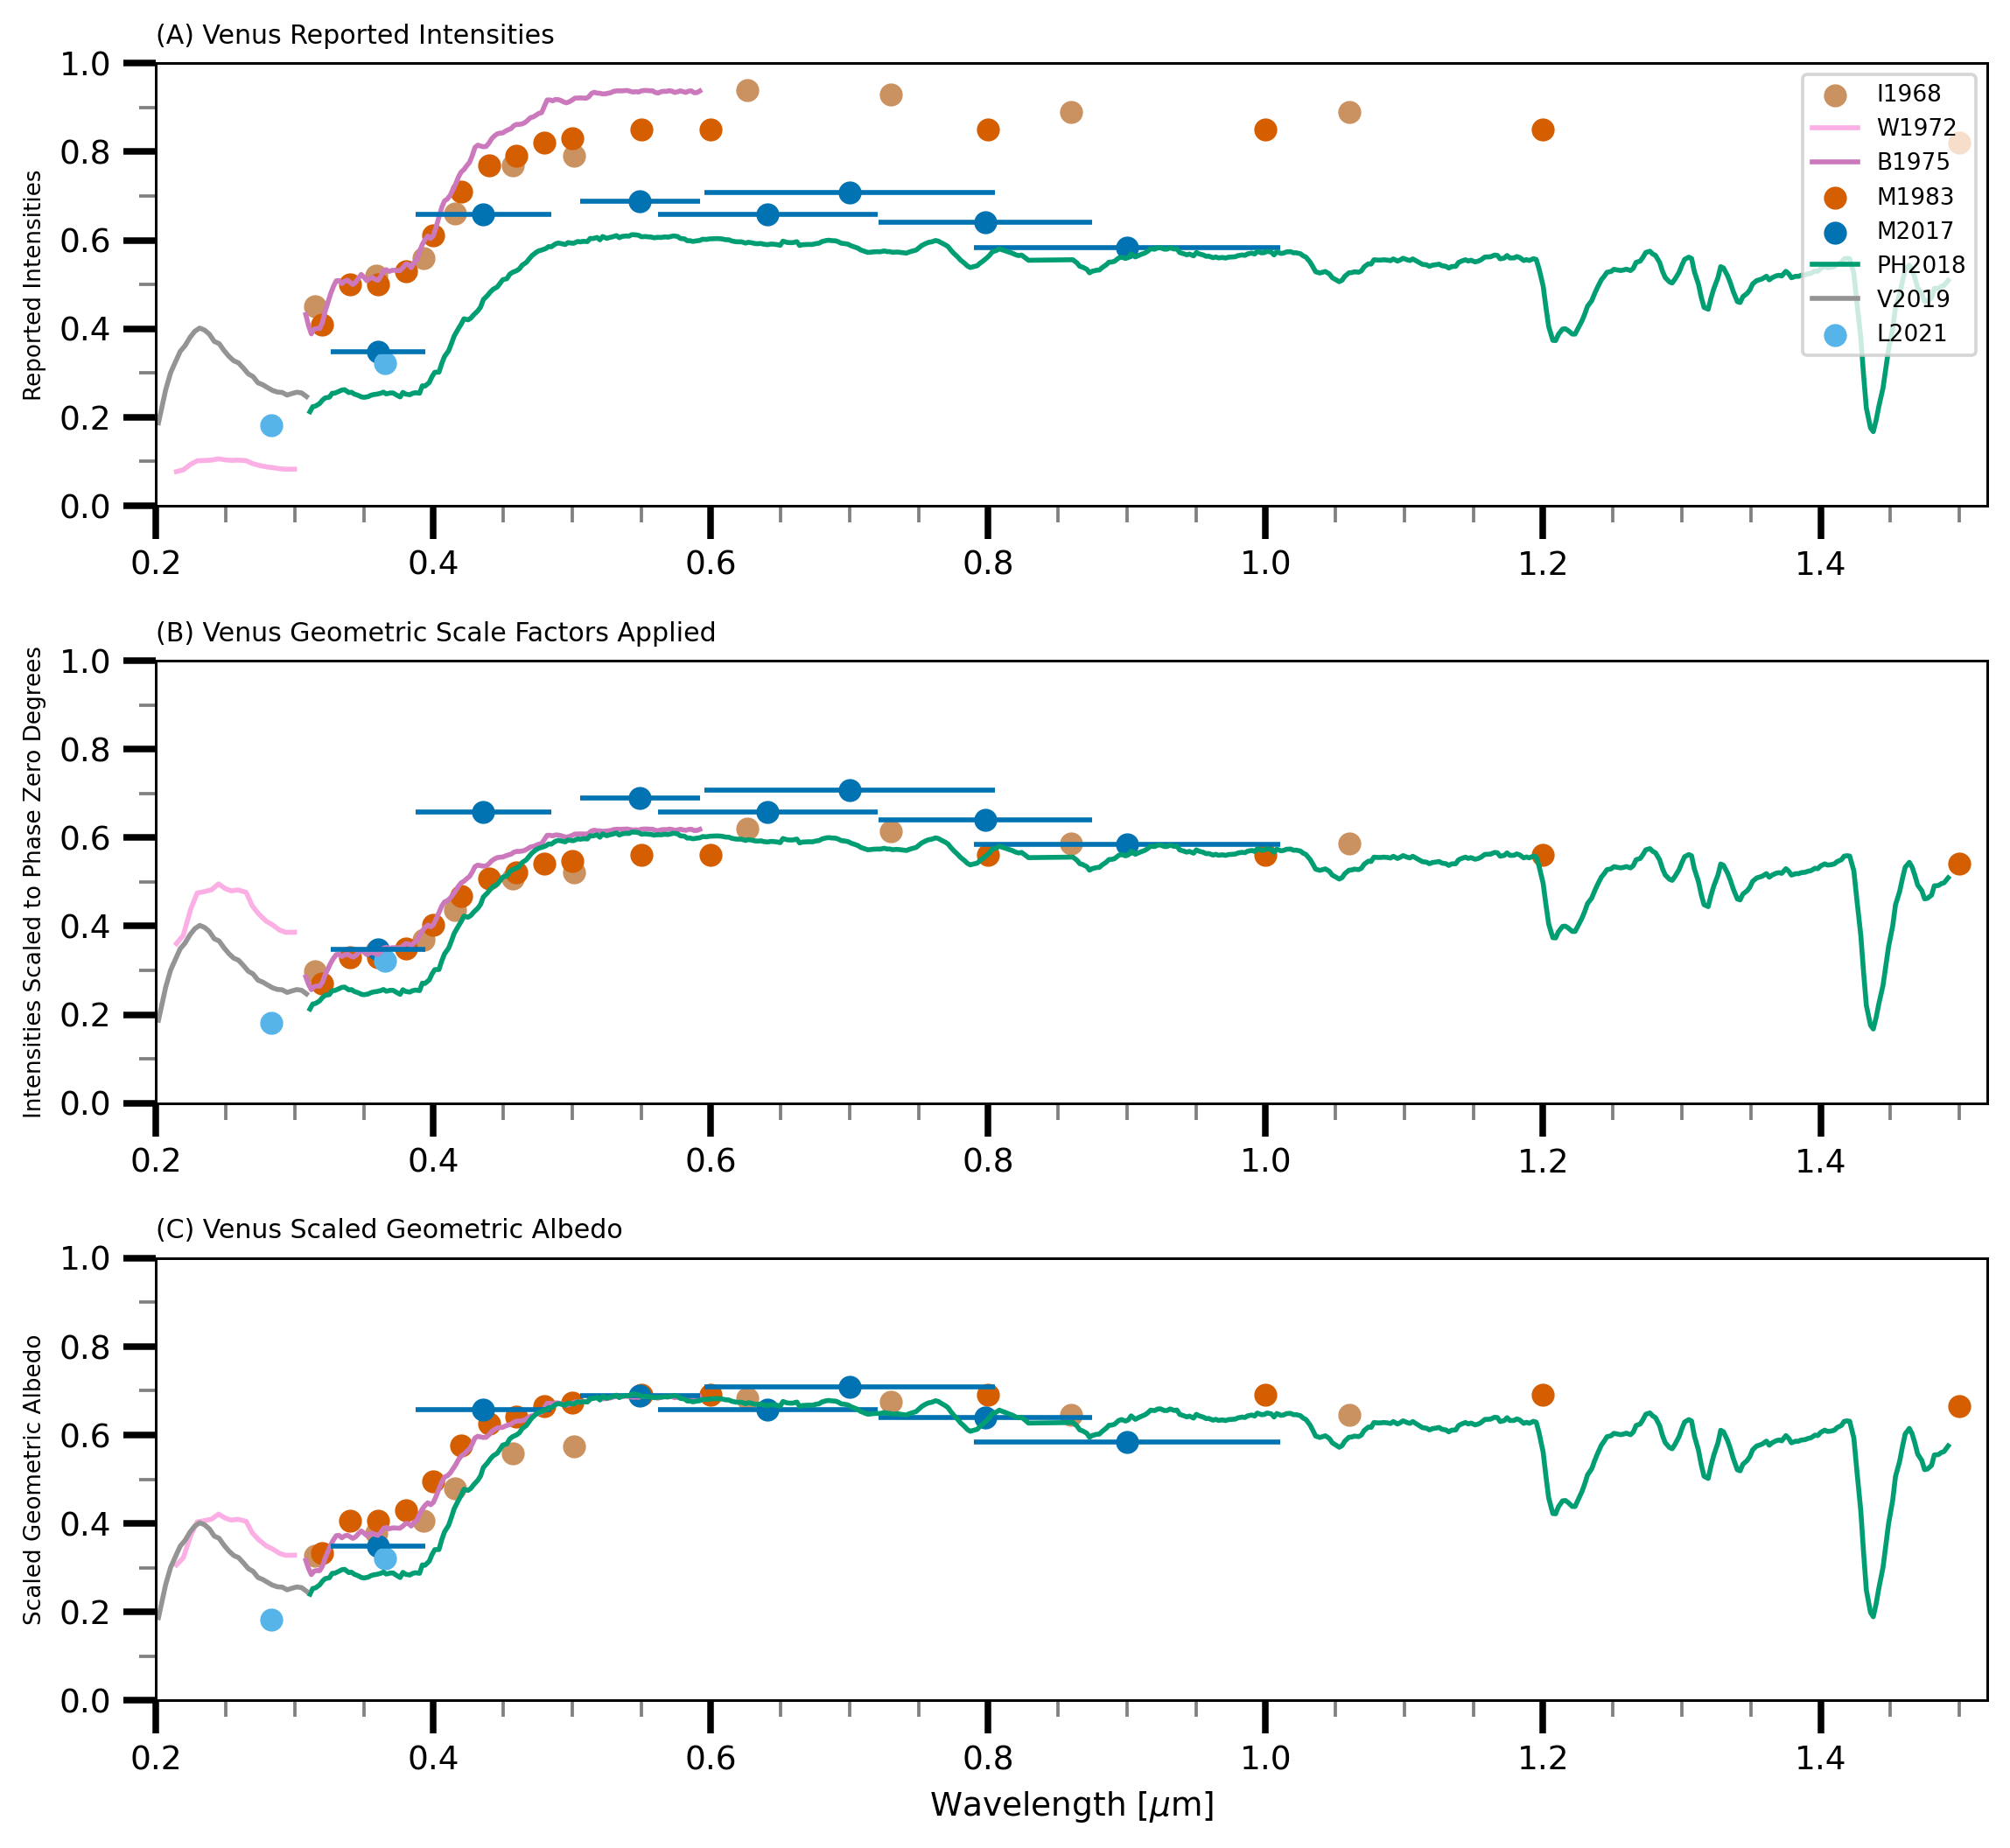

In [21]:
# Create figure and axes
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 9), dpi=270)
plt.subplots_adjust(hspace=0.35)

# DATA 
# FIGURE 1- ORIGINAL DATA
axes[0].scatter(irvine[:,0], irvine[:,1], label='I1968', color=cb_palette[5])
axes[0].plot(wallace[:,0], wallace[:,1], label='W1972', color=cb_palette[6])
axes[0].plot(barker[:,0], barker[:,1]*0.94, label='B1975', color=cb_palette[4])
axes[0].scatter(moroz[:,0], moroz[:,1], label='M1983', color=cb_palette[3])
#axes[0].plot(meadows['x'],meadows['y'], label='M2006', color=cb_palette[4], linestyle='--') #Data from original source
axes[0].errorbar(mallama_jc[:,0], mallama_jc[:,1], xerr=mallama_jc[:,2]/2, color=cb_palette[0], linestyle='none')
axes[0].scatter(mallama_jc[:,0], mallama_jc[:,1], label='M2017', color=cb_palette[0])
# axes[0].plot(roberge['Wavelength [$\\mu$m]'], roberge['Venus'], label='R2017', color=cb_palette[6], linestyle='--')
axes[0].plot(hoyos[mask][:,0],averaged_data_point5, label='PH2018',color=cb_palette[2]) #Data from original source
axes[0].plot(spicav['x'], spicav['y'], label='V2019', color=cb_palette[7])
axes[0].scatter(akatsuki_points_lee[:,0], akatsuki_points_lee[:,1], label='L2021', color=cb_palette[9])

# # FIGURE 2- GEOMETRIC SCALING FACTORS APPLIED
axes[1].scatter(irvine[:,0], irvine[:,1]*0.66, label='I1968', color=cb_palette[5])
axes[1].plot(wallace[:,0], wallace[:,1]/get_scale_factor_lambert(103), label='W1972', color=cb_palette[6])
axes[1].plot(barker[:,0], barker[:,1]*0.94*0.66, label='B1975', color=cb_palette[4])
axes[1].scatter(moroz[:,0], moroz[:,1]*0.66, label='M1983', color=cb_palette[3])
#axes[1].plot(meadows['x'],meadows['y'], label='M2006', color=cb_palette[4], linestyle='--') #Data from original source
axes[1].errorbar(mallama_jc[:,0], mallama_jc[:,1], xerr=mallama_jc[:,2]/2, color=cb_palette[0], linestyle='none')
axes[1].scatter(mallama_jc[:,0], mallama_jc[:,1], label='M2017', color=cb_palette[0])
# axes[1].plot(roberge['Wavelength [$\\mu$m]'], roberge['Venus'], label='R2017', color=cb_palette[6], linestyle='--')
axes[1].plot(hoyos[mask][:,0],averaged_data_point5, label='PH2018',color=cb_palette[2]) #Data from original source
axes[1].plot(spicav['x'], spicav['y'], label='V2019', color=cb_palette[7])
axes[1].scatter(akatsuki_points_lee[:,0], akatsuki_points_lee[:,1], label='L2021', color=cb_palette[9])

# # FIGURE 3- EMPIRICAL SCALING FACTORS
axes[2].scatter(irvine[:,0], irvine[:,1]*0.66*1.1, label='I1968', color=cb_palette[5])
axes[2].plot(wallace[:,0], (wallace[:,1]/ get_scale_factor_lambert(103))*0.85, label='W1972', color=cb_palette[6])
axes[2].plot(barker[:,0], barker[:,1]*0.94*0.66*1.11, label='B1975', color=cb_palette[4])
axes[2].scatter(moroz[:,0], moroz[:,1]*0.66*1.23, label='M1983', color=cb_palette[3])
#axes[2].plot(meadows['x'],meadows['y']*1.4, label='M2006', color=cb_palette[4], linestyle='--') #Data from original source
axes[2].errorbar(mallama_jc[:,0], mallama_jc[:,1], xerr=mallama_jc[:,2]/2, color=cb_palette[0], linestyle='none')
axes[2].scatter(mallama_jc[:,0], mallama_jc[:,1], label='M2017', color=cb_palette[0])
# axes[2].plot(roberge['Wavelength [$\\mu$m]'], roberge['Venus']*1.1, label='R2017', color=cb_palette[6], linestyle='--')
axes[2].plot(hoyos[mask][:,0],averaged_data_point5*1.13, label='PH2018',color=cb_palette[2]) #Data from original source
axes[2].plot(spicav['x'], spicav['y'], label='V2019', color=cb_palette[7])
axes[2].scatter(akatsuki_points_lee[:,0], akatsuki_points_lee[:,1], label='L2021', color=cb_palette[9])
#axes[2].plot(composite_df['x_1'],composite_df['y_1'], linewidth=3, zorder=0, color='black')
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~FORMAT~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for value in range(3):
    # Keeping the tick marks consistent across the plots
    axes[value].xaxis.set_major_locator(MultipleLocator(0.2))
    axes[value].xaxis.set_minor_locator(MultipleLocator(0.05))
    axes[value].yaxis.set_major_locator(MultipleLocator(0.2))
    axes[value].yaxis.set_minor_locator(MultipleLocator(0.1))
    # Customize the appearance of ticks
    axes[value].tick_params(axis='both', which='major', length=10, width=2, color='black')
    axes[value].tick_params(axis='both', which='minor', length=5, width=1, color='gray')
    axes[value].set_xlim(0.2,1.52)
    axes[value].set_ylim(0,1)

axes[0].set_title('(A) Venus Reported Intensities', fontsize=8 , loc='left')
axes[1].set_title('(B) Venus Geometric Scale Factors Applied', fontsize=8, loc='left')
axes[2].set_title('(C) Venus Scaled Geometric Albedo', fontsize=8, loc='left')
axes[0].set_ylabel('Reported Intensities', fontsize=7)
axes[1].set_ylabel('Intensities Scaled to Phase Zero Degrees', fontsize=7)
axes[2].set_ylabel('Scaled Geometric Albedo', fontsize=7)
axes[2].set_xlabel('Wavelength [$\mu$m]')
axes[0].legend(fontsize=7, loc='upper right') #, bbox_to_anchor=(0.4, 0.37), fancybox=True, shadow=True, ncol=3) #bbox_to_anchor=(1,0.7),
plt.savefig('final_plots/Venus_triplot.png', bbox_inches='tight');

# The Composite Spectrum

In [23]:
x_1= list(spicav[spicav['x']<0.309]['x'])
y_1= list(spicav[spicav['x']<0.309]['y'])

x_2= hoyos[hoyos[:,0]>0.309][:,0]
y_2= (averaged_data_point5*1.13)

x_new= np.concatenate((x_1, x_2))
y_new= np.concatenate((y_1, y_2))

composite_df= pd.DataFrame({'x_1': x_new, 'y_1': y_new})

x_dashed=composite_df[(composite_df['x_1'] > 1.491) & (composite_df['x_1'] < 1.4965)]['x_1']
y_dashed=composite_df[(composite_df['x_1'] > 1.491) & (composite_df['x_1'] < 1.4965)]['y_1']

# Save Composite Data
- Saving as csv and txt file

In [31]:
composite_df.to_csv('composite_spectrum/venus_composite_data.csv', index=False)
composite_df.to_csv('composite_spectrum/venus_composite_data.txt', sep=' ', index=False)

# Composite Spectrum 
- (not used in the paper, but shown for reference here)

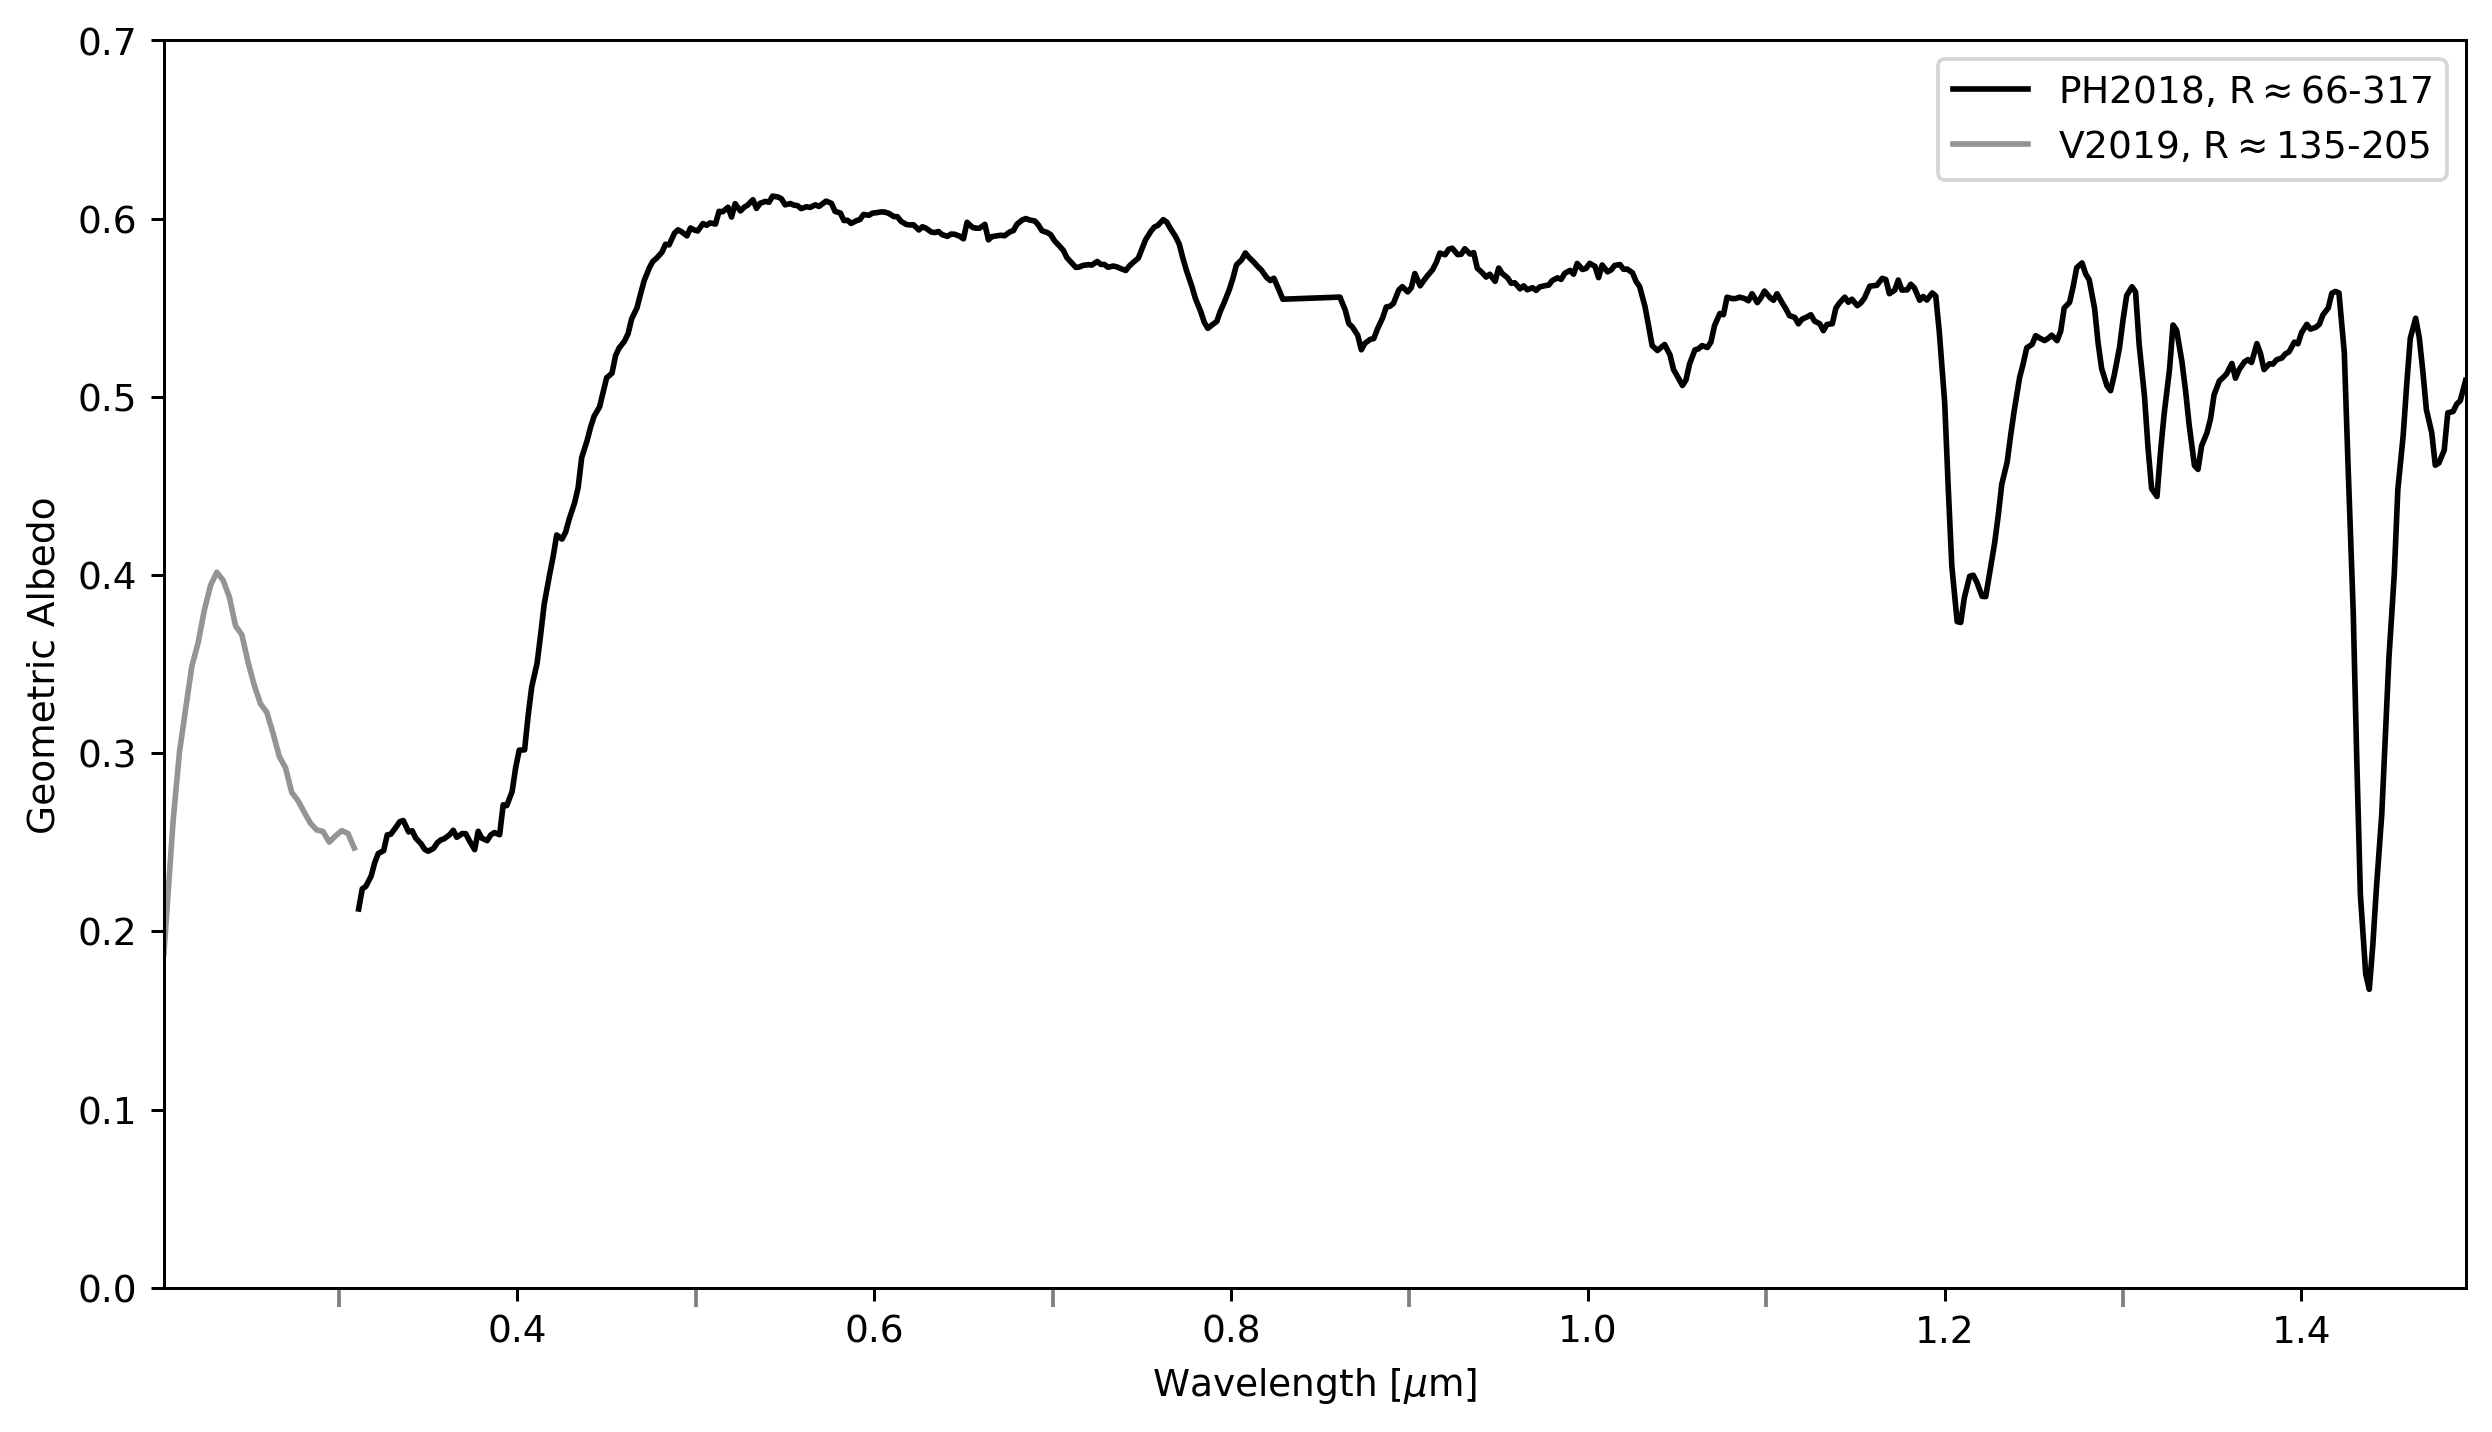

In [29]:
plt.figure(figsize=(11,6), dpi=270)

plt.plot(hoyos[mask][:,0],averaged_data_point5, label=r'PH2018, R$\approx$66-317',color='black') #Data from original source
plt.plot(spicav['x'], spicav['y'], label=r'V2019, R$\approx$135-205', color=cb_palette[7])

#plt.xscale('log')
plt.legend(loc='upper right')
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.1))
plt.gca().tick_params(axis='both', which='minor', length=5, width=1, color='gray')
plt.ylim(0,0.7)

#plt.xlim(0.28,0.35)
plt.xlim(spicav['x'].min(),hoyos[mask][:,0].max())
plt.xlabel('Wavelength [$\mu$m]')
plt.ylabel('Geometric Albedo')
plt.savefig('final_plots/venus_composite.png', bbox_inches="tight") ;